# 🍫 Creative common license dataset

> ⚠️ Please note that this notebook is not compatible with Google Colab. To complete the tutorial, you must initiate Docker containers. Starting Docker containers within Google Colab is not supported.

This sample pipeline demonstrates how to effectively utilize a creative
commons image dataset within a fondant pipeline. This dataset comprises images from diverse sources and is available in various data formats.
[The dataset](https://huggingface.co/datasets/fondant-ai/fondant-cc-25m) itself is available on Huggingface.



### Pipeline overview

The primary goal of this sample is to showcase how you can use a Fondant pipeline and reusable
components to load an image dataset from HuggingFace Hub and download all images.
Pipeline Steps:

- [Load from Huggingface Hub](https://github.com/ml6team/fondant/tree/main/components/load_from_hf_hub):
  The pipeline begins by loading the image dataset from Huggingface Hub.
- [Download Images](https://github.com/ml6team/fondant/tree/main/components/download_images): 
  The download image component download images and stores them to parquet. 
- [Filter Images](https://github.com/ml6team/fondant/tree/main/components/filter_image_resolution):
  The filter image component filters images based on their resolution.

## Environment
### This section checks the prerequisites of your environment. Read any errors or warnings carefully.

**Ensure a Python between version 3.8 and 3.10 is available**

In [2]:
import sys
if sys.version_info < (3, 8, 0) or sys.version_info >= (3, 11, 0):
    raise Exception(f"A Python version between 3.8 and 3.10 is required. You are running {sys.version}")

**Check if docker compose is installed and the docker daemon is running**

In [3]:
!docker compose version >/dev/null
!docker info >/dev/null

**Install Fondant**

In [ ]:
!pip install -r ../requirements.txt

## Implement the pipeline

First of all, we need to initialize the pipeline, which includes specifying a name for your pipeline, providing a description, and setting a base_path. The base_path is used to store the pipeline artifacts and data generated by the components.

In [8]:
from pathlib import Path

import pyarrow as pa

from fondant.pipeline import Pipeline

BASE_PATH = "./fondant-artifacts"

# Create data directory if it doesn't exist
Path(BASE_PATH).mkdir(parents=True, exist_ok=True)

pipeline = Pipeline(
    name="filter-creative-commons",  # Add a unique pipeline name to easily track your progress and data
    description="Load cc image dataset",
    base_path=BASE_PATH, # The demo pipelines uses a local directory to store the data.
)

For demonstration purposes, we will utilize a dataset available on HuggingFace. As such, we will use a reusable Fondant component `load_from_hf_hub`. The `load_from_hf_hub` component is a generic one, which implies that we still need to specify the produce section of the component (explicitly name and type the fields te component will generate, you find the available fields on the [huggingface dataset](https://huggingface.co/datasets/fondant-ai/fondant-cc-25m)).


Add the following to your pipeline file:

In [9]:
# Load from hub component
raw_data = pipeline.read(
    "load_from_hf_hub",
    arguments={
        "dataset_name": "fondant-ai/fondant-cc-25m",
        "n_rows_to_load": 100,  # Modify the number of images you want to download.
    },
    produces={
        "alt_text": pa.string(),
        "image_url": pa.string(),
        "license_location": pa.string(),
        "license_type": pa.string(),
        "webpage_url": pa.string(),
        "surt_url": pa.string(),
        "top_level_domain": pa.string(),
    }
)

Currently, our pipeline comprises a single component responsible for loading the dataset from the HuggingFace Hub. We have the flexibility to include additional components in the pipeline. In this instance, our objective is to download all the images. For this purpose, we will employ a reusable component named `download_images`. We apply the `download_images` component to the `load_from_hf_hub` component. This way we tell Fondant that this step should follow the previous one.

In [10]:
# Download images component
images = raw_data.apply(
    "download_images",
    arguments={
        "input_partition_rows": 100,
        "resize_mode": "no",
    }
)

Reusable components offer various arguments that typically affect the component's operations. In this case, we have set, for example, `"resize_mode": "no"`. This setting ensures that the images will not be resized after they are downloaded. If you would like to learn more about components and their arguments, please refer to our [documentation](https://fondant.ai) and explore the [ComponentHub](https://hub.fondant.ai).

Lets add one more step to our pipeline. We will filter the downloaded images based on their resolution. We will use the `filter_image_resolution` component for this purpose. This component requires two arguments: `min_width` and `max_aspect_ratio`. We will set these arguments so only images with a minimum resolution of 512 pixels will be kept.

In [11]:
# Filter images component
big_images = images.apply(
    "filter_image_resolution",
    arguments={
        "min_image_dim": 512,
        "max_aspect_ratio": 2.5,
    }
)

## Execute the pipeline

Now we are ready to execute our pipeline. 
Fondant provides various executors, and in this case, we are using the LocalRunner, which utilizes Docker under the hood.

In [12]:
# If you are using a MacBook with a M1 processor you have to make sure to set the docker default platform to linux/amd64
import os
os.environ["DOCKER_DEFAULT_PLATFORM"]="linux/amd64"

[2023-12-07 15:22:36,530 | root | INFO] Found reference to un-compiled pipeline... compiling
[2023-12-07 15:22:36,530 | fondant.pipeline.compiler | INFO] Compiling filter-creative-commons to .fondant/compose.yaml
[2023-12-07 15:22:36,531 | fondant.pipeline.compiler | INFO] Base path found on local system, setting up ./fondant-artifacts as mount volume
[2023-12-07 15:22:36,532 | fondant.pipeline.pipeline | INFO] Sorting pipeline component graph topologically.
[2023-12-07 15:22:36,544 | fondant.pipeline.pipeline | INFO] All pipeline component specifications match.
[2023-12-07 15:22:36,544 | fondant.pipeline.compiler | INFO] Compiling service for load_from_hub
[2023-12-07 15:22:36,545 | fondant.pipeline.compiler | INFO] Compiling service for download_images
[2023-12-07 15:22:36,546 | fondant.pipeline.compiler | INFO] Compiling service for filter_image_resolution
[2023-12-07 15:22:36,553 | fondant.pipeline.compiler | INFO] Successfully compiled to .fondant/compose.yaml
 load_from_hub Pulli

Attaching to filter-creative-commons-download_images-1, filter-creative-commons-filter_image_resolution-1, filter-creative-commons-load_from_hub-1


filter-creative-commons-load_from_hub-1            | [2023-12-07 14:22:43,133 | fondant.cli | INFO] Component `LoadFromHubComponent` found in module main
filter-creative-commons-load_from_hub-1            | [2023-12-07 14:22:43,141 | fondant.component.executor | INFO] Dask default local mode will be used for further executions.Our current supported options are limited to 'local' and 'default'.
filter-creative-commons-load_from_hub-1            | [2023-12-07 14:22:43,144 | fondant.component.executor | INFO] No matching execution for component detected
filter-creative-commons-load_from_hub-1            | [2023-12-07 14:22:43,144 | root | INFO] Executing component
filter-creative-commons-load_from_hub-1            | [2023-12-07 14:22:43,145 | main | INFO] Loading dataset from the hub...
filter-creative-commons-load_from_hub-1            | [2023-12-07 14:22:53,440 | main | INFO] Renaming columns...
filter-creative-commons-load_from_hub-1            | [2023-12-07 14:22:54,747 | main | INFO]

[                                        ] | 0% Completed | 428.29 us
[########################################] | 100% Completed | 107.20 ms
filter-creative-commons-load_from_hub-1            | 
filter-creative-commons-load_from_hub-1            | 
filter-creative-commons-load_from_hub-1 exited with code 0


filter-creative-commons-download_images-1          | [2023-12-07 14:22:59,344 | fondant.cli | INFO] Component `DownloadImagesComponent` found in module main
filter-creative-commons-download_images-1          | [2023-12-07 14:22:59,350 | fondant.component.executor | INFO] Dask default local mode will be used for further executions.Our current supported options are limited to 'local' and 'default'.
filter-creative-commons-download_images-1          | [2023-12-07 14:22:59,353 | fondant.component.executor | INFO] Previous component `load_from_hub` is not cached. Invalidating cache for current and subsequent components
filter-creative-commons-download_images-1          | [2023-12-07 14:22:59,353 | fondant.component.executor | INFO] Caching disabled for the component
filter-creative-commons-download_images-1          | [2023-12-07 14:22:59,353 | root | INFO] Executing component
filter-creative-commons-download_images-1          | [2023-12-07 14:23:02,905 | fondant.component.data_io | INFO] T

[                                        ] | 0% Completed | 182.04 us
[                                        ] | 0% Completed | 100.66 ms
[                                        ] | 0% Completed | 201.11 ms
[                                        ] | 0% Completed | 301.78 ms
[                                        ] | 0% Completed | 402.77 ms
[                                        ] | 0% Completed | 503.23 ms
[                                        ] | 0% Completed | 603.91 ms
[                                        ] | 0% Completed | 704.75 ms
[                                        ] | 0% Completed | 805.32 ms
[                                        ] | 0% Completed | 905.86 ms
[                                        ] | 0% Completed | 1.01 s
[                                        ] | 0% Completed | 1.11 s
[                                        ] | 0% Completed | 1.21 s
[                                        ] | 0% Completed | 1.31 s
[                               

filter-creative-commons-download_images-1          | [2023-12-07 14:23:07,124 | main | INFO] Downloading 50 images...


[###########                             ] | 28% Completed | 4.17 s
[###########                             ] | 28% Completed | 4.27 s
[###########                             ] | 28% Completed | 4.37 s
[###########                             ] | 28% Completed | 4.48 s
[###########                             ] | 28% Completed | 4.58 s
[###########                             ] | 28% Completed | 4.68 s
[###########                             ] | 28% Completed | 4.78 s
[###########                             ] | 28% Completed | 4.89 s
[###########                             ] | 28% Completed | 4.99 s
[###########                             ] | 28% Completed | 5.09 s
[###########                             ] | 28% Completed | 5.19 s
[###########                             ] | 28% Completed | 5.29 s
[###########                             ] | 28% Completed | 5.40 s
[###########                             ] | 28% Completed | 5.50 s
[###########                             ] | 28%

filter-creative-commons-download_images-1          | [2023-12-07 14:23:08,877 | httpx | INFO] HTTP Request: GET http://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png "HTTP/1.1 301 Moved Permanently"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:08,914 | main | WARNING] Skipping http://catalogo.fondazionezeri.unibo.itfoto\120000\84800\84488.jpg: ConnectError('[Errno -2] Name or service not known')
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,029 | main | WARNING] Skipping http://catalogo.fondazionezeri.unibo.itimages/icons/rdf_24.png: ConnectError('[Errno -2] Name or service not known')
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,037 | main | WARNING] Skipping http://catalogo.fondazionezeri.unibo.itimages/icons/cc-by-nc.png: ConnectError('[Errno -2] Name or service not known')
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,038 | main | WARNING] Skipping http://catalogo.fondazio

[###########                             ] | 28% Completed | 6.02 s
[###########                             ] | 28% Completed | 6.12 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,096 | httpx | INFO] HTTP Request: GET http://acikerisim.erdogan.edu.tr/xmlui/static/dokumanlar/images/google.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,115 | httpx | INFO] HTTP Request: GET http://acikerisim.erdogan.edu.tr/xmlui/static/dokumanlar/images/oai.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,118 | httpx | INFO] HTTP Request: GET http://acikerisim.erdogan.edu.tr/xmlui/static/dokumanlar/images/roar.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,119 | httpx | INFO] HTTP Request: GET http://acikerisim.erdogan.edu.tr/xmlui/static/dokumanlar/images/harman.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,119 | httpx | INFO] HTTP Request: GET http://acikerisim.erdogan.edu.tr/xmlui/themes/Mirage2//images/DSpace-logo

[###########                             ] | 28% Completed | 6.22 s
[###########                             ] | 28% Completed | 6.32 s
[###########                             ] | 28% Completed | 6.42 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,309 | httpx | INFO] HTTP Request: GET https://i.creativecommons.org/l/by/4.0/88x31.png "HTTP/1.1 301 Moved Permanently"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,312 | httpx | INFO] HTTP Request: GET https://licensebuttons.net/l/by-nc-nd/4.0/88x31.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,336 | httpx | INFO] HTTP Request: GET http://cms.deshabhimani.com/images/socialIn-twitter.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,337 | httpx | INFO] HTTP Request: GET http://cms.deshabhimani.com/images/news/thumb/2023/05/0ari-1089475.jpg "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,340 | httpx | INFO] HTTP Request: GET http://cms.deshabhimani.com/images/news/thumb/2023/05/0par-1089595.jpg "HTTP/1.1 200 OK"
filter-creative-commons-download_ima

[###########                             ] | 28% Completed | 6.52 s
[###########                             ] | 28% Completed | 6.62 s
[###########                             ] | 28% Completed | 6.72 s
[###########                             ] | 28% Completed | 6.83 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,705 | main | INFO] Downloading 50 images...
filter-creative-commons-download_images-1          | [2023-12-07 14:23:09,901 | main | WARNING] Skipping http://en.techinfodepot.shoutwiki.com: InvalidURL("Invalid port: 'image'")

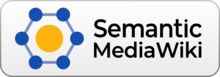

[###########                             ] | 28% Completed | 6.93 s
[###########                             ] | 28% Completed | 7.04 s
[###########                             ] | 28% Completed | 7.14 s
[###########                             ] | 28% Completed | 7.24 s
[###########                             ] | 28% Completed | 7.34 s
[###########                             ] | 28% Completed | 7.44 s
[###########                             ] | 28% Completed | 7.54 s
[###########                             ] | 28% Completed | 7.65 s
[###########                             ] | 28% Completed | 7.75 s
[###########                             ] | 28% Completed | 7.85 s
[###########                             ] | 28% Completed | 7.96 s
[###########                             ] | 28% Completed | 8.06 s
[###########                             ] | 28% Completed | 8.16 s
[###########                             ] | 28% Completed | 8.26 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,125 | httpx | INFO] HTTP Request: GET http://i.creativecommons.org/l/by-nc-nd/3.0/88x31.png "HTTP/1.1 301 Moved Permanently"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,198 | httpx | INFO] HTTP Request: GET http://cnt.rm.ingv.it/images/flags/it.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,264 | httpx | INFO] HTTP Request: GET https://i0.wp.com/assets.pinterest.com/images/pidgets/pinit_fg_en_rect_gray_20.png?w=1080 "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,266 | httpx | INFO] HTTP Request: GET https://i0.wp.com/i.creativecommons.org/l/by-nc-sa/4.0/88x31.png?w=1080&ssl=1 "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,271 | httpx | INFO] HTTP Request: GET https://i.creativecommons.org/l/by-sa/4.0/88x31.png "HTTP/1.1 301 Moved Permanently"
filt

[###########                             ] | 28% Completed | 8.37 s
[###########                             ] | 28% Completed | 8.47 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,327 | httpx | INFO] HTTP Request: GET http://klaster-plasy.cz/pamatky/plasy/fotogalerie/ilustracni-foto/image-thumb__153437__TourCircuitPreviewImage/obrazek_plasy_front.jpg "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,327 | httpx | INFO] HTTP Request: GET http://klaster-plasy.cz/pamatky/plasy/fotogalerie/ilustracni-foto/image-thumb__150971__auto_c08470639e893839727f29dc3c52e72c/mapa_schema.jpg "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,349 | httpx | INFO] HTTP Request: GET http://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png "HTTP/1.1 301 Moved Permanently"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,403 | httpx | INFO] HTTP Request: GET http://farseerfc.me "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,404 | httpx | INFO] HTTP Request: GET htt

[###########                             ] | 28% Completed | 8.57 s
[###########                             ] | 28% Completed | 8.68 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,580 | httpx | INFO] HTTP Request: GET http://en.techinfodepot.shoutwiki.com/w/resources/assets/poweredby_mediawiki_88x31.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,581 | httpx | INFO] HTTP Request: GET http://en.techinfodepot.shoutwiki.com/w/resources/assets/licenses/cc-by-sa.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,596 | httpx | INFO] HTTP Request: GET http://www.shoutwiki.com/w/hosted_by_ShoutWiki.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,668 | httpx | INFO] HTTP Request: GET http://news.coinsblog.ws/wp-includes/images/rss.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:11,677 | httpx | INFO] HTTP Request: GET http://news.coinsblog.ws/wp-content/uploads/sites/3/2017/03/CoinsBlog-News.png "HTTP/1.1 200 OK"


[###########                             ] | 28% Completed | 8.78 s
[###########                             ] | 28% Completed | 8.88 s
[###########                             ] | 28% Completed | 8.99 s
[###########                             ] | 28% Completed | 9.09 s
[###########                             ] | 28% Completed | 9.19 s
[###########                             ] | 28% Completed | 9.29 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:12,167 | httpx | INFO] HTTP Request: GET http://opus.sanbi.org/image/dspace-logo-only.png "HTTP/1.1 200 OK"


[###########                             ] | 28% Completed | 9.39 s
[###########                             ] | 28% Completed | 9.49 s
[###########                             ] | 28% Completed | 9.59 s
[###########                             ] | 28% Completed | 9.70 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:12,680 | httpx | INFO] HTTP Request: GET https://licensebuttons.net/l/by-nc-nd/3.0/88x31.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:12,683 | httpx | INFO] HTTP Request: GET https://licensebuttons.net/l/by-sa/4.0/88x31.png "HTTP/1.1 200 OK"
filter-creative-commons-download_images-1          | [2023-12-07 14:23:12,688 | httpx | INFO] HTTP Request: GET https://licensebuttons.net/l/by-nc-sa/4.0/80x15.png "HTTP/1.1 200 OK"


[###########                             ] | 28% Completed | 9.80 s
[###########                             ] | 28% Completed | 9.91 s
[###########                             ] | 28% Completed | 10.01 s
[###########                             ] | 28% Completed | 10.12 s
[###########                             ] | 28% Completed | 10.22 s
[###########                             ] | 28% Completed | 10.33 s
[###########                             ] | 28% Completed | 10.43 s
[###########                             ] | 28% Completed | 10.54 s
[###########                             ] | 28% Completed | 10.64 s
[###########                             ] | 28% Completed | 10.74 s
[###########                             ] | 28% Completed | 10.84 s
[###########                             ] | 28% Completed | 10.94 s
[###########                             ] | 28% Completed | 11.05 s
[###########                             ] | 28% Completed | 11.15 s
[###########                        

filter-creative-commons-download_images-1          | [2023-12-07 14:23:21,126 | main | WARNING] Skipping http://romor.iugaza.edu.ps/romor/images/bt-workshop-gal/vsig_thumbs/21439638_985340711605564_1181860007_o_92_32_80.jpg: ConnectTimeout('')
filter-creative-commons-download_images-1          | [2023-12-07 14:23:21,130 | main | WARNING] Skipping http://romor.iugaza.edu.ps/romor/images/fair_gallery/vsig_thumbs/img4_92_36_80.jpg: ConnectTimeout('')
filter-creative-commons-download_images-1          | [2023-12-07 14:23:21,130 | main | WARNING] Skipping http://romor.iugaza.edu.ps/romor/images/br_galley/images/vsig_thumbs/ROMOR_WP3_SMS_Poster_060919_92_46_80.png: ConnectTimeout('')
filter-creative-commons-download_images-1          | [2023-12-07 14:23:21,131 | main | WARNING] Skipping http://romor.iugaza.edu.ps/romor/images/bt-workshop-gal/vsig_thumbs/IMG_20170906_131345_92_32_80.jpg: ConnectTimeout('')
filter-creative-commons-download_images-1          | [2023-12-07 14:23:21,131 | main | 

[######################                  ] | 57% Completed | 18.32 s
[########################################] | 100% Completed | 18.42 s


filter-creative-commons-download_images-1          | [2023-12-07 14:23:22,080 | fondant.component.executor | INFO] Saving output manifest to /fondant-artifacts/filter-creative-commons/filter-creative-commons-20231207152236/download_images/manifest.json
filter-creative-commons-download_images-1          | [2023-12-07 14:23:22,081 | fondant.component.executor | INFO] Writing cache key to /fondant-artifacts/filter-creative-commons/cache/2c7a109b4292bedf2693e74034bd7494.txt


filter-creative-commons-download_images-1 exited with code 0


filter-creative-commons-filter_image_resolution-1  | [2023-12-07 14:23:26,756 | fondant.cli | INFO] Component `FilterImageResolutionComponent` found in module main
filter-creative-commons-filter_image_resolution-1  | [2023-12-07 14:23:26,763 | fondant.component.executor | INFO] Dask default local mode will be used for further executions.Our current supported options are limited to 'local' and 'default'.
filter-creative-commons-filter_image_resolution-1  | [2023-12-07 14:23:26,805 | fondant.component.executor | INFO] Previous component `download_images` is not cached. Invalidating cache for current and subsequent components
filter-creative-commons-filter_image_resolution-1  | [2023-12-07 14:23:26,805 | fondant.component.executor | INFO] Caching disabled for the component
filter-creative-commons-filter_image_resolution-1  | [2023-12-07 14:23:26,805 | root | INFO] Executing component
filter-creative-commons-filter_image_resolution-1  | [2023-12-07 14:23:27,144 | fondant.component.data_io 

[                                        ] | 0% Completed | 849.21 us
[#########                               ] | 23% Completed | 104.81 ms
[######################                  ] | 57% Completed | 205.53 ms
[########################################] | 100% Completed | 307.09 ms


filter-creative-commons-filter_image_resolution-1  | [2023-12-07 14:23:27,497 | fondant.component.executor | INFO] Saving output manifest to /fondant-artifacts/filter-creative-commons/filter-creative-commons-20231207152236/filter_image_resolution/manifest.json
filter-creative-commons-filter_image_resolution-1  | [2023-12-07 14:23:27,497 | fondant.component.executor | INFO] Writing cache key to /fondant-artifacts/filter-creative-commons/cache/84bce02fdaefa0f6cc76f11df6b52251.txt


filter-creative-commons-filter_image_resolution-1 exited with code 0


In [13]:
from fondant.pipeline.runner import DockerRunner

DockerRunner().run(input=pipeline)

## Exploring the dataset

You can also explore the dataset using the fondant explorer, this enables you to visualize your output dataset at each component step.


In [14]:
from fondant.explore import run_explorer_app

run_explorer_app(
    base_path=BASE_PATH,
    container="fndnt/data_explorer",
    tag="latest",
    port=8501
)

[2023-12-07 15:23:43,445 | root | INFO] Using local base path: ./fondant-artifacts
[2023-12-07 15:23:43,445 | root | INFO] This directory will be mounted to /artifacts in the container.
[2023-12-07 15:23:43,446 | root | INFO] Running image from registry: fndnt/data_explorer with tag: latest on port: 8501
[2023-12-07 15:23:43,446 | root | INFO] Access the explorer at http://localhost:8501
latest: Pulling from fndnt/data_explorer
Digest: sha256:9efea540e97395fa362b293e0fdd6b624486485507a3dd04f591476dc16ed9a7
Status: Downloaded newer image for fndnt/data_explorer:latest
2023-12-07 14:23:57.710 Uncaught app exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 87, in get
    entry_bytes = self._read_from_mem_cache(key)
  File "/usr/local/lib/python3.8/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 137, in _read_from_mem_cache
    raise

KeyboardInterrupt: 